In [36]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [37]:
#Read tweets from csv file
df=pd.read_csv("../Raw Data/Trump tweets 3 day groups jan-dec 2017.csv")
df.head()

,text,created_at,Unique Identifier
0,It all begins today! I will see you at 11:00 A...,1/20/2017,1
1,Today we are not merely transferring power fro...,1/20/2017,1
2,power from Washington D.C. and giving it back ...,1/20/2017,1
3,What truly matters is not which party controls...,1/20/2017,1
4,January 20th 2017 will be remembered as the da...,1/20/2017,1


In [38]:
#Changing the date format
for index, row in df.iterrows():
    #row['startdate']=row['startdate'].date()
    d= datetime.strptime(row['created_at'], '%m/%d/%Y')
    df.loc[index, 'created_at'] = d.strftime('%Y-%m-%d')
df.head()

,text,created_at,Unique Identifier
0,It all begins today! I will see you at 11:00 A...,2017-01-20,1
1,Today we are not merely transferring power fro...,2017-01-20,1
2,power from Washington D.C. and giving it back ...,2017-01-20,1
3,What truly matters is not which party controls...,2017-01-20,1
4,January 20th 2017 will be remembered as the da...,2017-01-20,1


In [39]:
#first tweet variable
#true for the first time then set to false
firstTweet = True

#list to store compound sentiment for each tweet
#once unique identifier is different averaged and emptied
compound_list =[]

#Array to store average compound sentiments
sentiments =[]
count =0

#Iterate over all the tweet data stored in dataframe
for index, row in df.iterrows():
    
    #Run Vader Analysis on each tweet
    sentence =row["text"]
    
    #Getting average compund sentiment for three days
    #Three days tweets have same unique identifier
    new_id =row["Unique Identifier"]
    
    #If not first tweet 
        ##Check if the old and new unique identifiers are different
            ####If different save the average compound sentiment
            ####Empty the compound list
            ####Add the average compound sentiment to an array
            ####Set the counter to 0
            ####Set the old_date  value
    #Else 
    ##Set firstTweet to false
    ##Set the ol_date for first set of sentiments 
    if(firstTweet == False):               
        if(old_id != new_id):
            compound= np.mean(compound_list)
            compound_list =[]
            sentiments.append({"Compound":compound,
                "Date" : old_date,
                "Count" : count})
            count =0
            old_date = row["created_at"]
    else:
        firstTweet = False
        old_date = row["created_at"]
    
    #Add all the tweet to compound list
    #Increment the counter
    #Change the old_id and old_values     
    compound_list.append(analyzer.polarity_scores(sentence)["compound"])
    count +=1
    old_id = new_id
        
#Add the final set of average compund sentiment
sentiments.append({"Compound":compound,
                "Date" : old_date,
                "Count" : count})

In [40]:
#Put all data into dataframe sentiments_df
sentiments_df = pd.DataFrame.from_dict(sentiments)
sentiments_df =sentiments_df[['Date','Compound','Count']]
sentiments_df.tail()

,Date,Compound,Count
111,2017-12-19,0.587037,16
112,2017-12-22,0.302471,21
113,2017-12-25,0.607490,10
114,2017-12-28,0.180156,25
115,2017-12-31,0.180156,1


In [ ]:
#Read tweets approval ratings from csv file
df1=pd.read_csv("../Raw Data/approval data clean values only.csv")
df1.head()

In [42]:
#Changing the date format
#Keeping only one date and renaming it to 'Date'
#Filtering the data to keep values only from 2017-01-20 to 2017-12-31
for index, row in df1.iterrows():
    d= datetime.strptime(row['Start Date'], '%m/%d/%Y')
    df1.loc[index, 'Start Date'] = d.strftime('%Y-%m-%d')
df1.rename( columns={"Start Date": "Date"}, inplace=True)
df1=df1.loc[(df1['Date'] > '2017-01-19') & (df1['Date'] < '2018-01-01')]
approval_df=df1[['Date','Average of adjusted_approve','Average of adjusted_disapprove']]
approval_df.tail()

,Date,Average of adjusted_approve,Average of adjusted_disapprove
104,2017-12-13,37.614145,57.895265
105,2017-12-16,36.906130,57.140930
106,2017-12-19,36.906130,56.140930
107,2017-12-28,40.906130,53.140930
108,2017-12-31,39.594297,54.633113


In [43]:
#Performing merge based on the 'Date' column
#Removing any rows having NaN values or no values
correlate_df =sentiments_df.merge(approval_df,on='Date',how="outer")
correlate_df =correlate_df[['Date','Compound','Average of adjusted_approve','Average of adjusted_disapprove']]
correlate_df.rename( columns={"Average of adjusted_approve": "Approve","Average of adjusted_disapprove": "Disapprove"}, inplace=True)
correlate_df = correlate_df.dropna(axis=0, how='any')
correlate_df.head()

,Date,Compound,Approve,Disapprove
0,2017-01-20,0.185511,45.90613,43.14093
1,2017-01-23,0.183223,43.71903,40.23624
2,2017-01-26,0.106478,42.90613,49.14093
3,2017-01-29,-0.232106,43.90613,50.14093
4,2017-02-01,0.069474,44.90613,48.14093


In [44]:
len(correlate_df)

109

In [ ]:
correlate_df.to_csv("../Clean Data/TweetVsApproval.csv")

In [46]:
#Convert compound sentiment range max being 1 and min being -1 into percentage. i.e -1 = 0% and 1 =100%
#((input - min) * 100) / (max - min)
max=1
min =-1
for index, row in correlate_df.iterrows():
    d= ((row['Compound'] - min) * 100) / (max - min)
    correlate_df.loc[index, 'Compound'] = d
correlate_df.head()

,Date,Compound,Approve,Disapprove
0,2017-01-20,59.275556,45.90613,43.14093
1,2017-01-23,59.161154,43.71903,40.23624
2,2017-01-26,55.323913,42.90613,49.14093
3,2017-01-29,38.394706,43.90613,50.14093
4,2017-02-01,53.473684,44.90613,48.14093


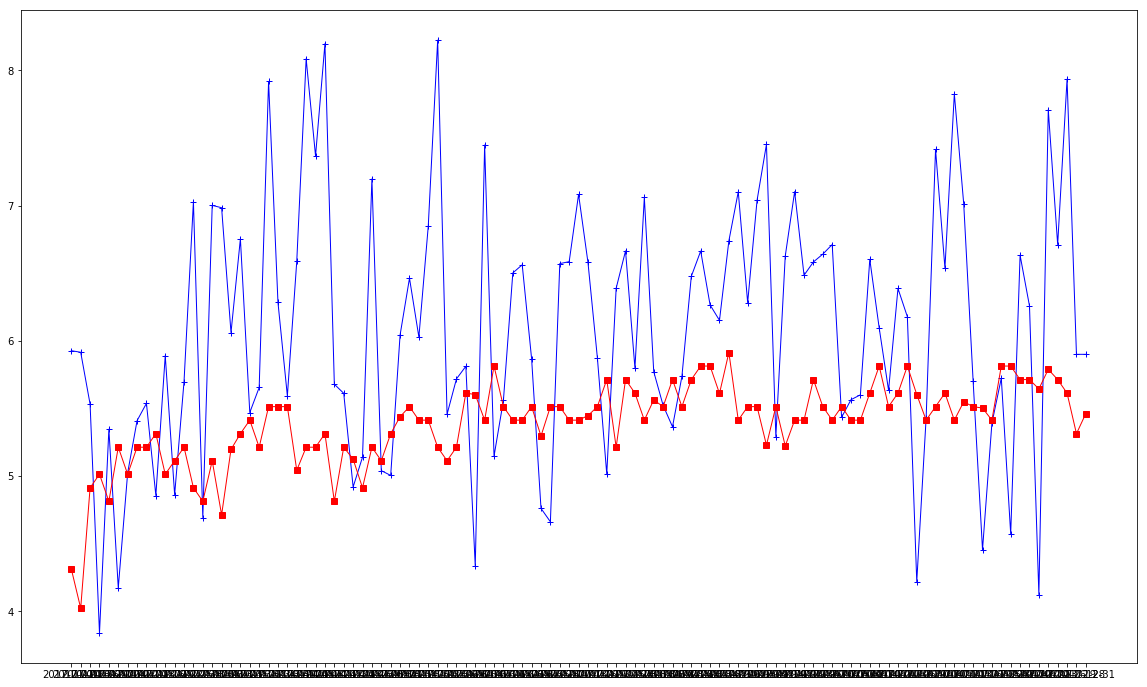

In [49]:
plt.figure(figsize=(20,12))
x_axis = correlate_df['Date']
# Create a handle for each plot
Compound = plt.plot(x_axis, correlate_df['Compound']/10, marker="+",color="blue", linewidth=1, label="Sentiment")
Approve = plt.plot(x_axis, correlate_df['Disapprove']/10, marker="s", color="Red", linewidth=1, label="Disapprove")

In [107]:
correlate_df.describe()

,Compound,Approve,Disapprove
count,109.000000,109.000000,109.000000
mean,60.768338,39.517613,53.893932
std,9.500038,2.484418,3.042327
min,38.394706,34.906130,40.236240
25%,54.706500,37.906130,52.140930
50%,60.284375,38.906130,54.140930
75%,66.644048,40.906130,55.636240
max,82.236000,45.906130,59.140930


In [102]:
#Narrowing data using the standard deviation
cleaned_df=correlate_df.loc[(correlate_df['Compound'] > 51) & (correlate_df['Compound'] < 69)]
cleaned_df =cleaned_df.tail(10)

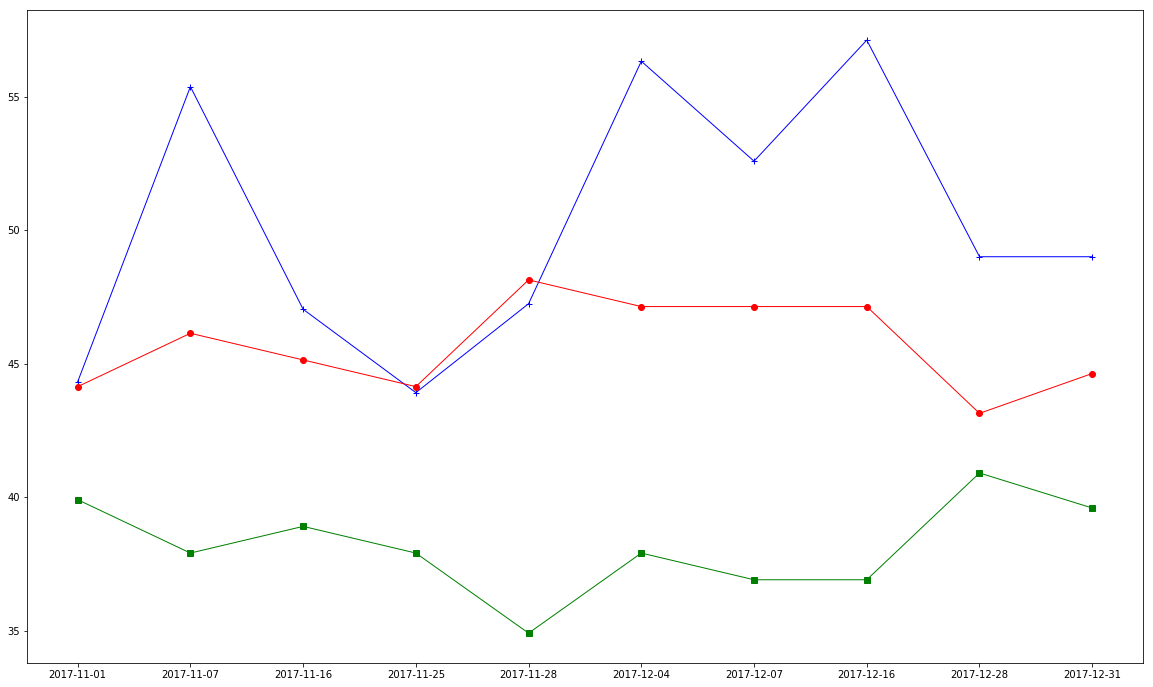

In [103]:
#Plotting line graph for bottom 10 of narrowed values
plt.figure(figsize=(20,12))
x_axis = cleaned_df['Date']

# Create a handle for each plot
Compound = plt.plot(x_axis, cleaned_df['Compound']-10, marker="+",color="blue", linewidth=1, label="Sentiment")
Approve = plt.plot(x_axis, cleaned_df['Approve'], marker="s", color="Green", linewidth=1, label="Approve")
Disapprove = plt.plot(x_axis, cleaned_df['Disapprove']-10, marker="o", color="Red", linewidth=1, label="Disapprove")

<Container object of 10 artists>

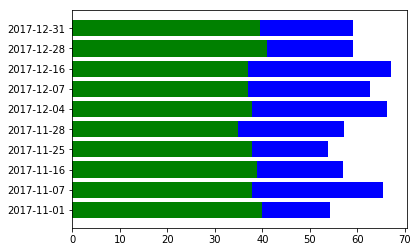

In [106]:
#Create a barplot for sentiment analysis and approval
plt.barh(x_axis, cleaned_df['Compound'], color="blue")
plt.barh(x_axis, cleaned_df['Approve'], color="green")

# Conclusions
### As time goes people seem to like him less and dislike him more regardless of the tweet sentiment
### 